In [2]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 80.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.



Informations sur l'enregistrement 100 :
Nombre de signaux : 2
Fréquence d'échantillonnage : 360 Hz
Nombre d'échantillons : 3600
Durée de l'enregistrement : 10.00 secondes
Noms des signaux : ['MLII', 'V5']


<Figure size 1500x800 with 0 Axes>

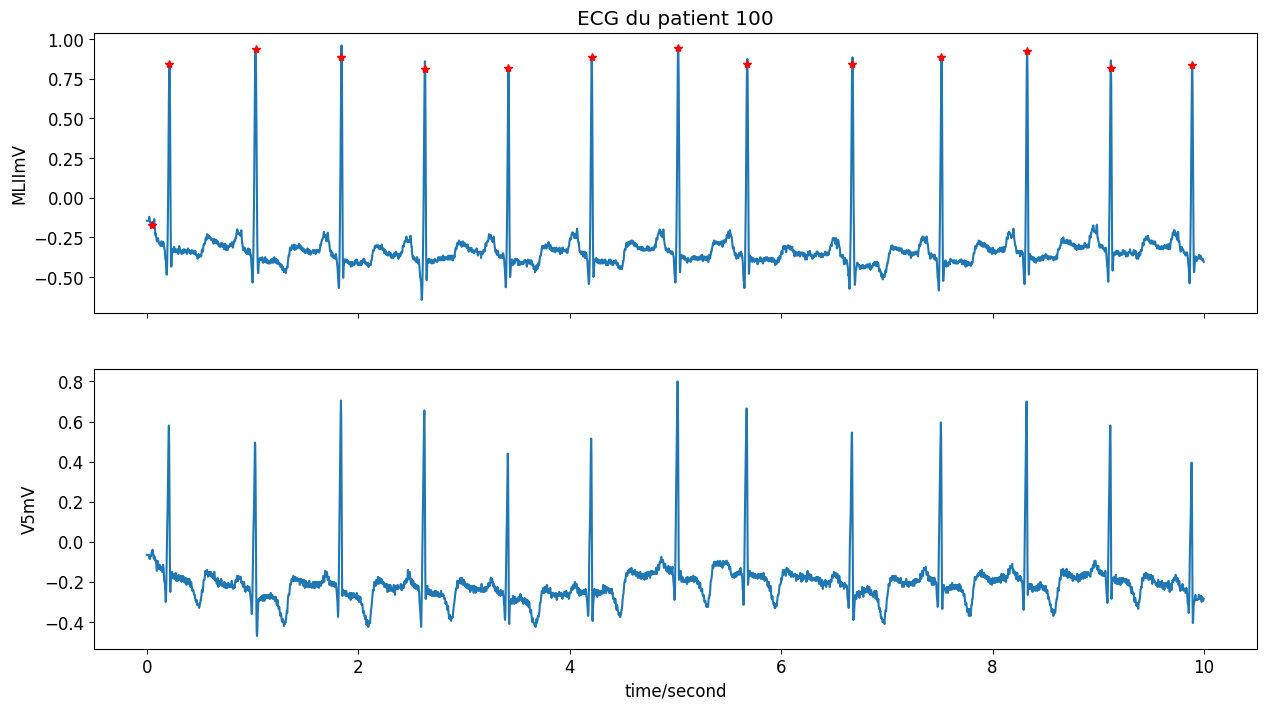

<Figure size 1500x800 with 0 Axes>

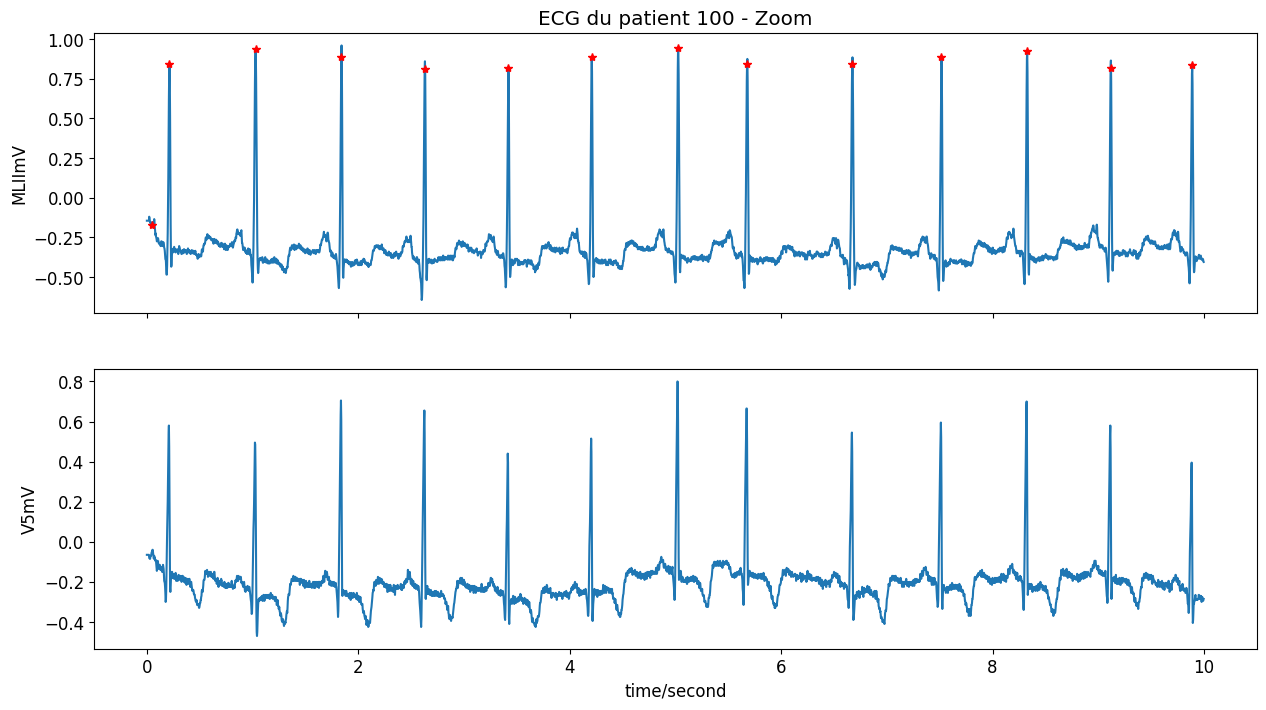

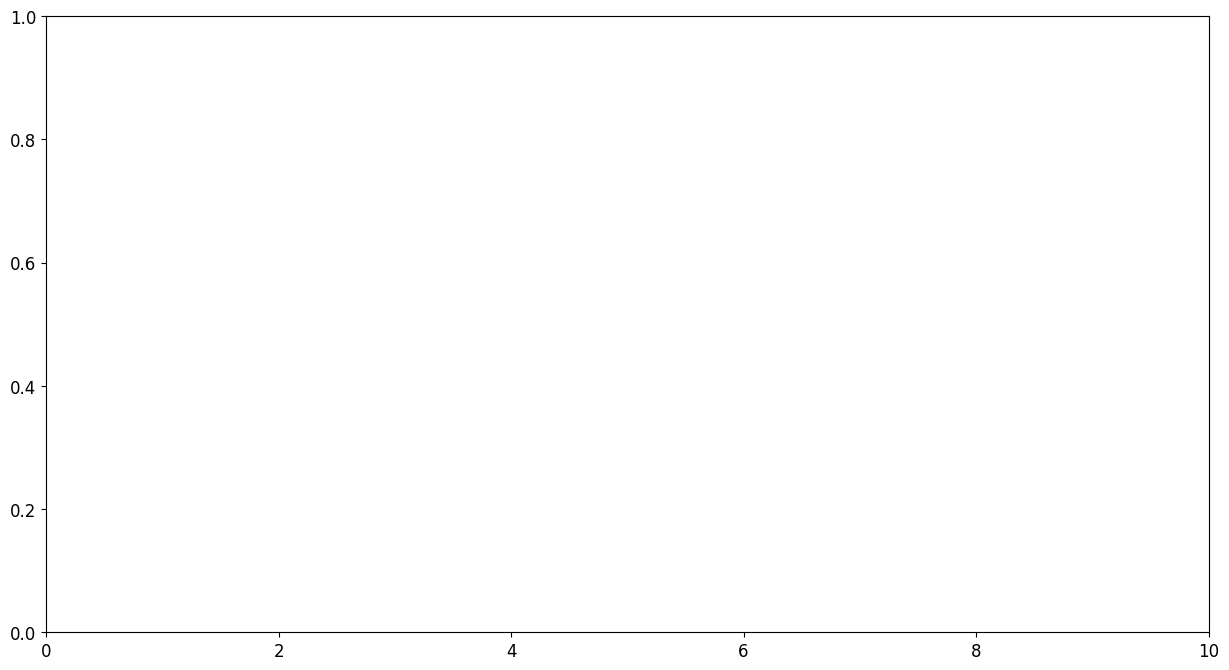


Distribution des types de battements :
N    12
+     1
A     1
Name: count, dtype: int64


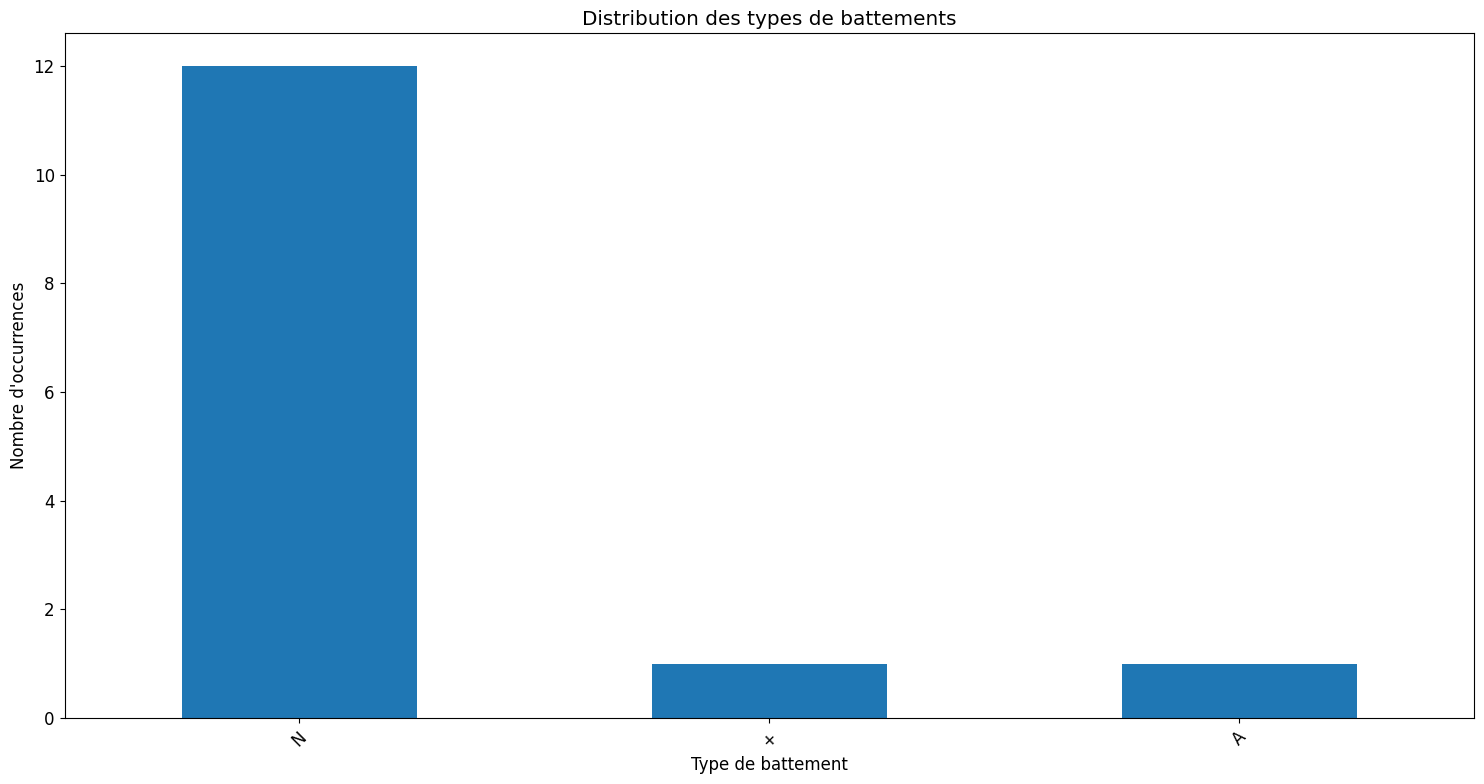


Premiers battements annotés :
   sample symbol      time
0      18      +  0.050000
1      77      N  0.213889
2     370      N  1.027778
3     662      N  1.838889
4     946      N  2.627778
5    1231      N  3.419444
6    1515      N  4.208333
7    1809      N  5.025000
8    2044      A  5.677778
9    2402      N  6.672222


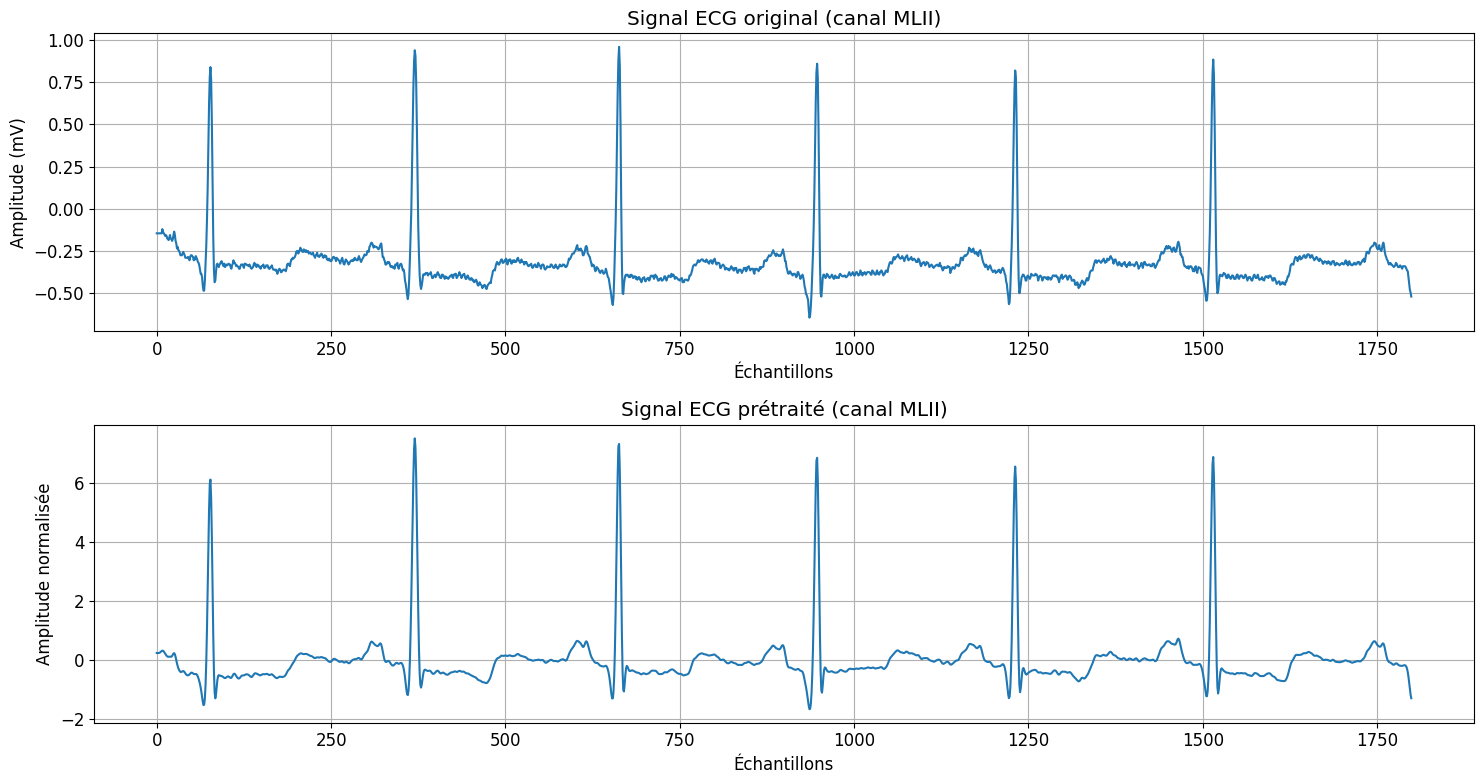


Statistiques des intervalles R-R :
Nombre de battements détectés : 11
Moyenne : 809.17 ms
Écart-type : 78.44 ms
Minimum : 652.78 ms
Maximum : 994.44 ms


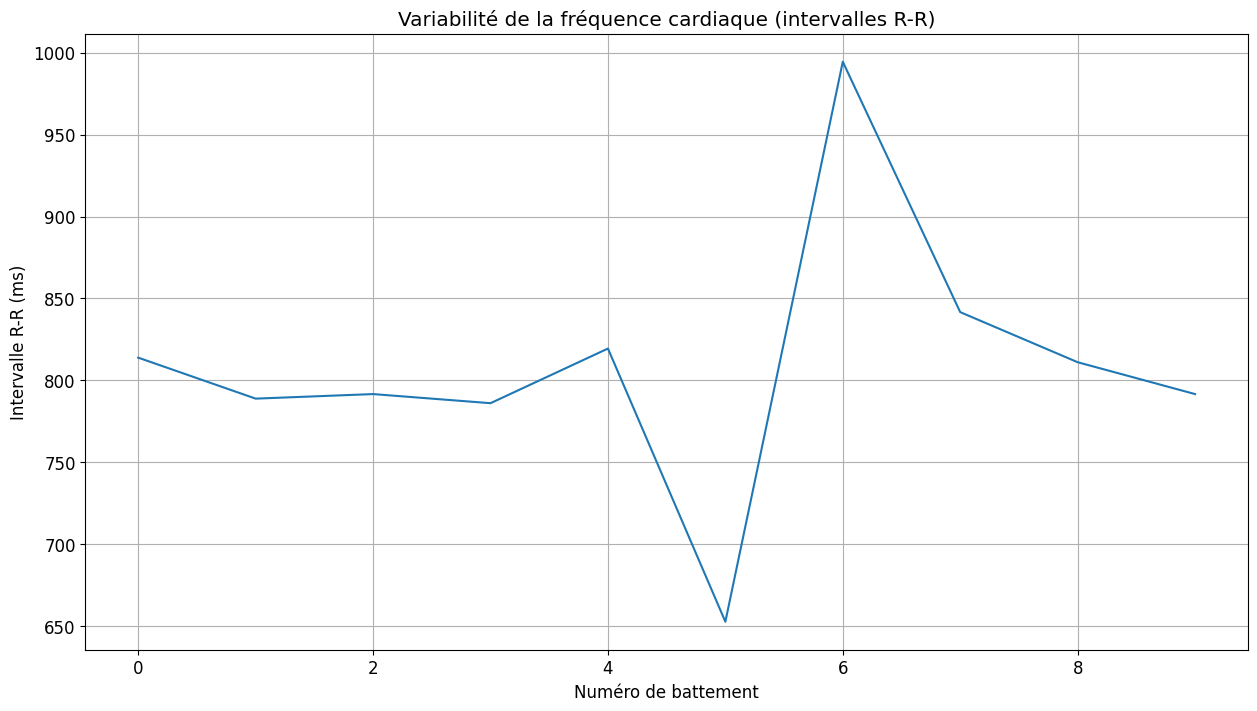

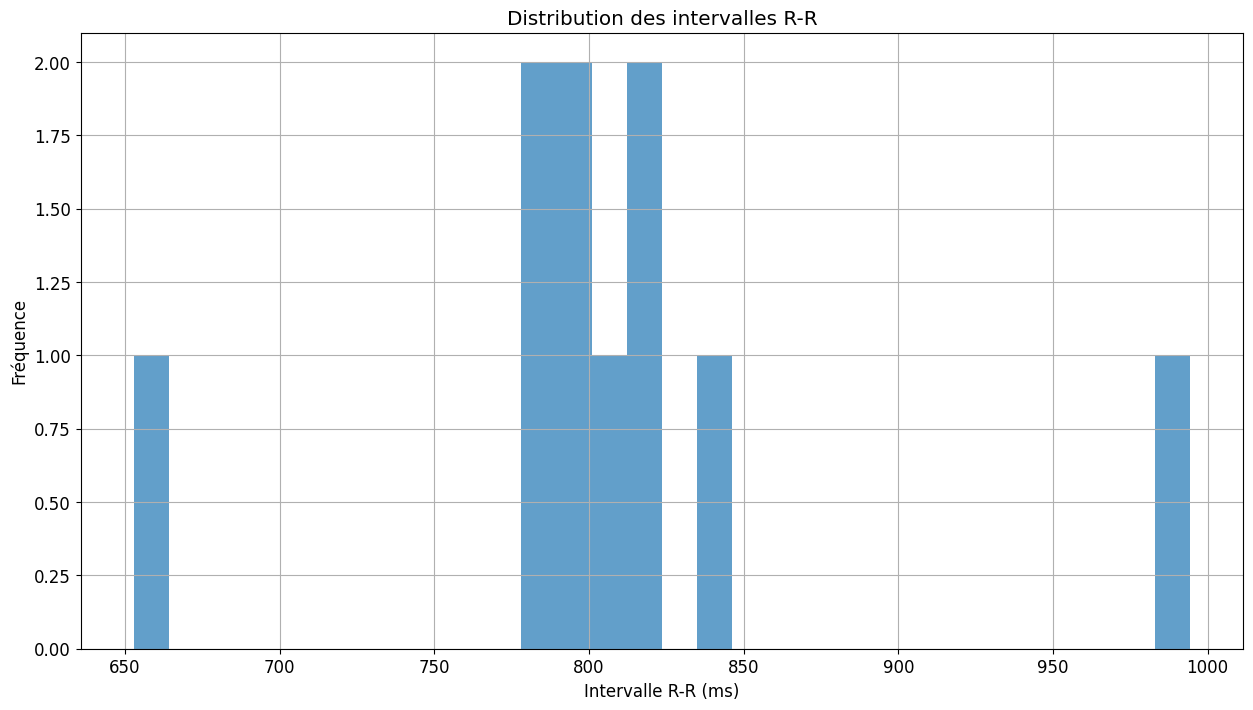


Nombre de battements segmentés : 11
Dimensions des battements : (11, 250)


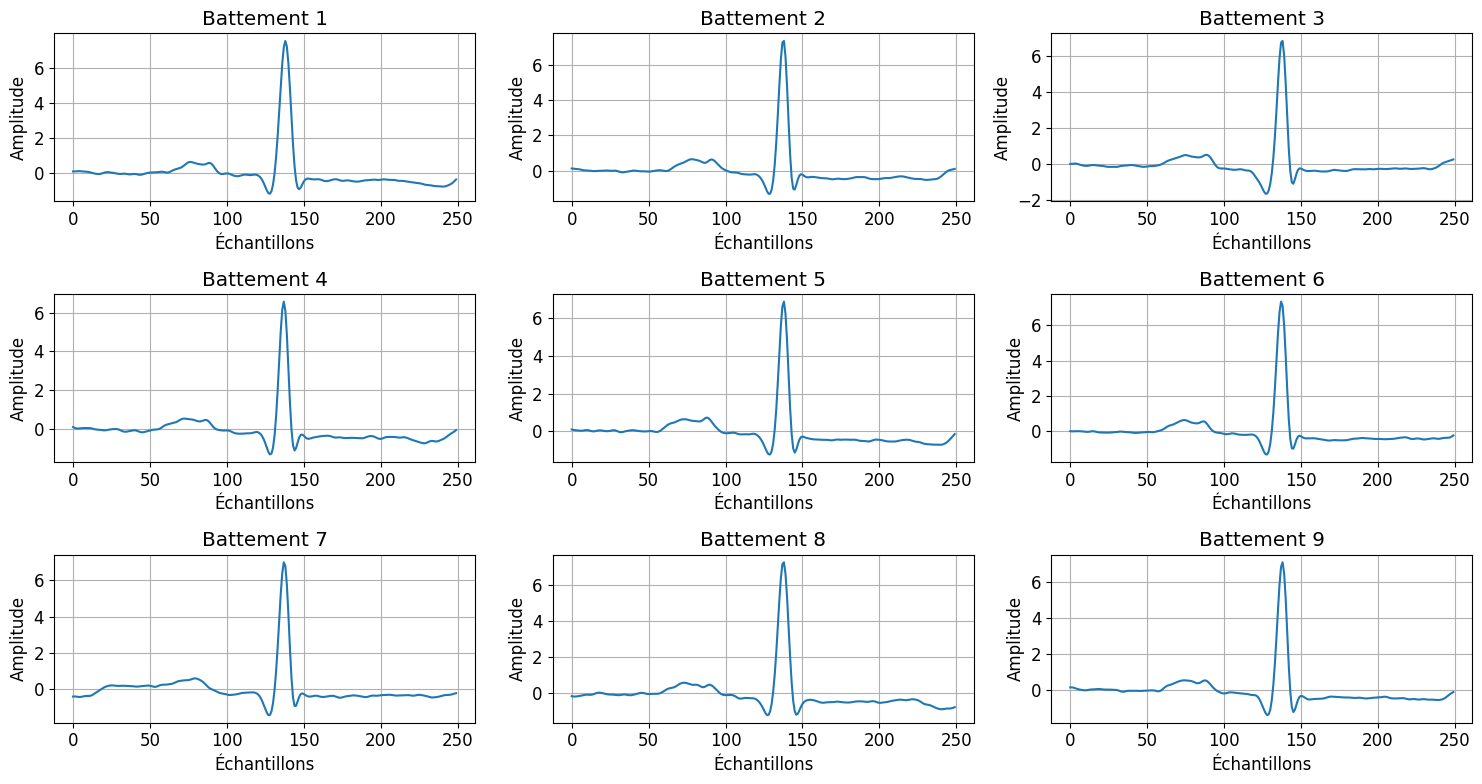

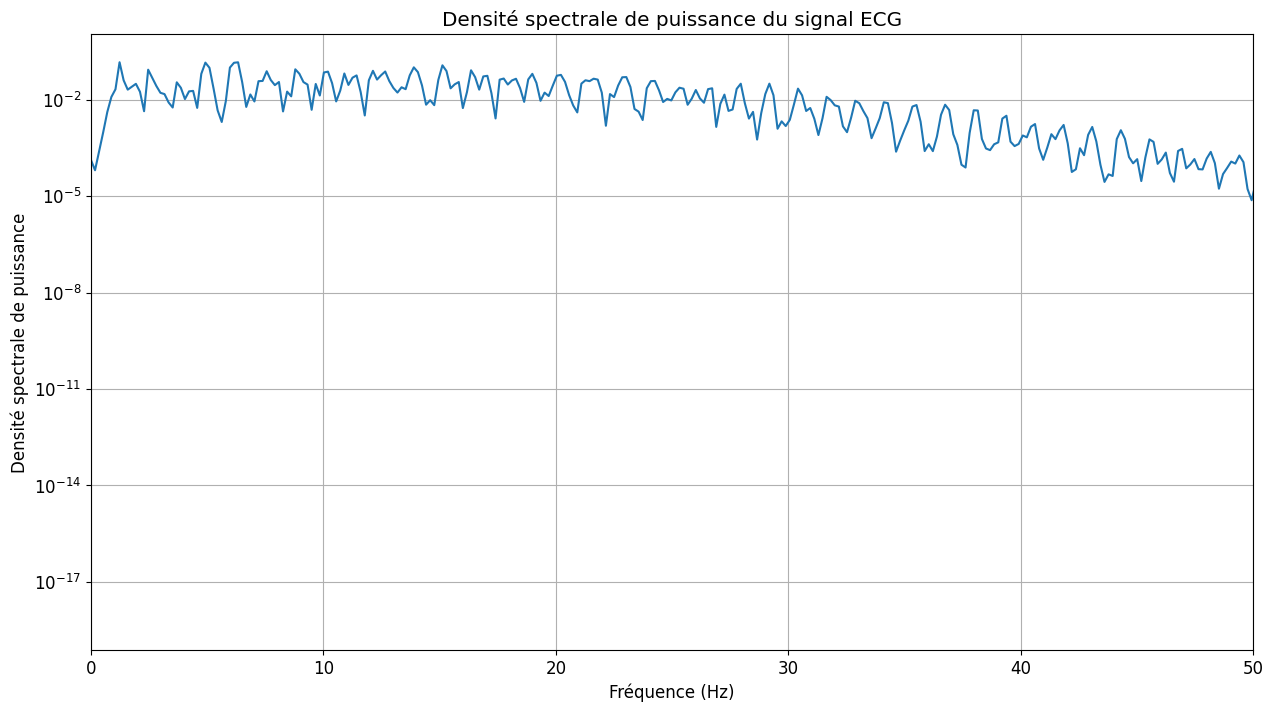

Type N: 10 battements
Type A: 1 battements


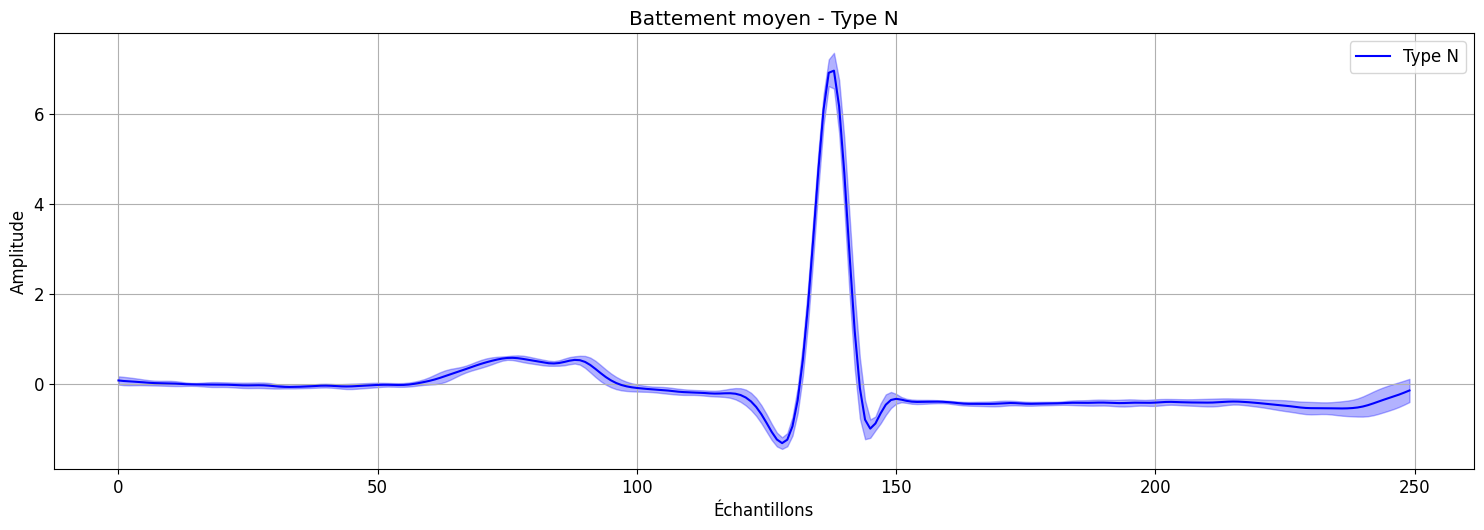


Conclusion de l'analyse descriptive :
- Le jeu de données MIT-BIH Arrhythmia contient 48 enregistrements ECG.
- L'enregistrement 100 analysé contient 11 battements.
- 3 types différents de battements ont été identifiés.
- Les intervalles R-R moyens sont de 809.17 ms, indiquant une fréquence cardiaque moyenne de 74.15 bpm.
- Le prétraitement des signaux a permis d'améliorer la qualité des données pour l'analyse.
- La segmentation des battements a permis d'extraire des motifs caractéristiques pour chaque type d'anomalie.
- Ces analyses serviront de base pour le développement d'un modèle de détection d'anomalies.


In [9]:
# Phase 1 : Comprendre les données - Analyse descriptive des signaux ECG
# BUT RT3 - Parcours Cybersécurité

# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing
from scipy import signal
import os

# Configuration de matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# 1. Chargement et exploration initiale des données
# ---------------------------------------------------

# Définition du chemin vers les données utilisation du téléchargement automatique
# Chargement d'un enregistrement d'exemple avec téléchargement automatique

record_id = '100'  # On peut changer cet ID pour explorer d'autres enregistrements
record = wfdb.rdrecord(record_id, sampto=3600, pn_dir='mitdb')
annotation = wfdb.rdann(record_id, 'atr', sampto=3600, pn_dir='mitdb')

# Affichage des informations de base
print(f"\nInformations sur l'enregistrement {record_id} :")
print(f"Nombre de signaux : {record.n_sig}")
print(f"Fréquence d'échantillonnage : {record.fs} Hz")
print(f"Nombre d'échantillons : {record.sig_len}")
print(f"Durée de l'enregistrement : {record.sig_len/record.fs:.2f} secondes")
print(f"Noms des signaux : {record.sig_name}")

# 2. Visualisation des signaux ECG
# ---------------------------------------------------

# Visualisation des canaux ECG
plt.figure()
wfdb.plot_wfdb(record=record, annotation=annotation,
               title=f"ECG du patient {record_id}",
               time_units='seconds', figsize=(15, 8))
plt.show()

# Zoom sur une portion du signal (10 secondes)
plt.figure()
wfdb.plot_wfdb(record=record, annotation=annotation,
               title=f"ECG du patient {record_id} - Zoom",
               time_units='seconds', figsize=(15, 8))
plt.xlim(0, 10)
plt.show()

# 3. Analyse des annotations
# ---------------------------------------------------

# Récupération des types d'annotations
symbols = annotation.symbol
samples = annotation.sample

# Comptage des différents types d'annotations
annotation_counts = pd.Series(symbols).value_counts()
print("\nDistribution des types de battements :")
print(annotation_counts)

# Visualisation de la distribution des annotations
plt.figure()
annotation_counts.plot(kind='bar')
plt.title('Distribution des types de battements')
plt.xlabel('Type de battement')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Création d'un DataFrame pour une analyse plus détaillée
annotations_df = pd.DataFrame({
    'sample': samples,
    'symbol': symbols,
    'time': samples / record.fs  # Conversion en secondes
})

# Affichage des premiers battements annotés
print("\nPremiers battements annotés :")
print(annotations_df.head(10))

# 4. Prétraitement des signaux
# ---------------------------------------------------

def preprocess_signal(signal_data, fs):
    """
    Prétraite un signal ECG en appliquant un filtrage et une normalisation

    Parameters:
    -----------
    signal_data : array
        Signal ECG à prétraiter
    fs : int
        Fréquence d'échantillonnage du signal

    Returns:
    --------
    preprocessed : array
        Signal ECG prétraité
    """
    # Filtre passe-bande (0.5-45 Hz)
    b, a = signal.butter(3, [0.5, 45], fs=fs, btype='band')
    filtered = signal.filtfilt(b, a, signal_data)

    # Normalisation
    normalized = (filtered - np.mean(filtered)) / np.std(filtered)

    return normalized

# Application du prétraitement
preprocessed_signal_0 = preprocess_signal(record.p_signal[:, 0], record.fs)
preprocessed_signal_1 = preprocess_signal(record.p_signal[:, 1], record.fs)

# Visualisation du signal avant et après prétraitement
plt.figure()
plt.subplot(211)
plt.plot(record.p_signal[:1800, 0])
plt.title('Signal ECG original (canal MLII)')
plt.xlabel('Échantillons')
plt.ylabel('Amplitude (mV)')
plt.grid(True)

plt.subplot(212)
plt.plot(preprocessed_signal_0[:1800])
plt.title('Signal ECG prétraité (canal MLII)')
plt.xlabel('Échantillons')
plt.ylabel('Amplitude normalisée')
plt.grid(True)

plt.tight_layout()
plt.show()

# 5. Détection des complexes QRS et analyse des intervalles R-R
# -------------------------------------------------------------

# Détection des complexes QRS (pics R)
qrs_inds = processing.gqrs_detect(sig=record.p_signal[:, 0], fs=record.fs)

# Calcul des intervalles R-R
rr_intervals = np.diff(qrs_inds) / record.fs * 1000  # en millisecondes

# Statistiques sur les intervalles R-R
print(f"\nStatistiques des intervalles R-R :")
print(f"Nombre de battements détectés : {len(qrs_inds)}")
print(f"Moyenne : {np.mean(rr_intervals):.2f} ms")
print(f"Écart-type : {np.std(rr_intervals):.2f} ms")
print(f"Minimum : {np.min(rr_intervals):.2f} ms")
print(f"Maximum : {np.max(rr_intervals):.2f} ms")

# Visualisation de la variabilité de la fréquence cardiaque
plt.figure()
plt.plot(rr_intervals)
plt.title('Variabilité de la fréquence cardiaque (intervalles R-R)')
plt.xlabel('Numéro de battement')
plt.ylabel('Intervalle R-R (ms)')
plt.grid(True)
plt.show()

# Histogramme des intervalles R-R
plt.figure()
plt.hist(rr_intervals, bins=30, alpha=0.7)
plt.title('Distribution des intervalles R-R')
plt.xlabel('Intervalle R-R (ms)')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

# 6. Segmentation des battements
# ---------------------------------------------------

def segment_beats(signal, qrs_indices, window_size=250):
    beats = []
    for qrs_idx in qrs_indices:
        # Vérification que la fenêtre ne sort pas des limites du signal
        if qrs_idx - window_size//2 >= 0 and qrs_idx + window_size//2 < len(signal):
            beat = signal[qrs_idx - window_size//2:qrs_idx + window_size//2]
            beats.append(beat)
    return np.array(beats)

# Extraction des battements
beats = segment_beats(preprocessed_signal_0, qrs_inds)

# Affichage du nombre de battements extraits
print(f"\nNombre de battements segmentés : {len(beats)}")
print(f"Dimensions des battements : {beats.shape}")

# Visualisation de quelques battements
plt.figure()
for i in range(min(9, len(beats))):
    plt.subplot(3, 3, i+1)
    plt.plot(beats[i])
    plt.title(f'Battement {i+1}')
    plt.xlabel('Échantillons')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

# 7. Analyse dans le domaine fréquentiel
# ---------------------------------------------------

# Analyse spectrale du signal complet
f, Pxx = signal.welch(preprocessed_signal_0, fs=record.fs, nperseg=2048)

plt.figure()
plt.semilogy(f, Pxx)
plt.title('Densité spectrale de puissance du signal ECG')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.xlim([0, 50])  # Limitation aux fréquences d'intérêt
plt.grid(True)
plt.show()

# 8. Analyse des différents types d'anomalies
# ---------------------------------------------------

# Création d'un dictionnaire pour stocker les battements par type
beats_by_type = {}

# Association des battements segmentés aux annotations
# Note: Cette approche simple associe chaque battement à l'annotation la plus proche
# Une approche plus précise nécessiterait de faire correspondre exactement les pics R aux annotations
for i, beat in enumerate(beats):
    # Trouver l'annotation la plus proche du pic R
    qrs_idx = qrs_inds[i]
    closest_ann_idx = np.argmin(np.abs(annotation.sample - qrs_idx))
    beat_type = annotation.symbol[closest_ann_idx]

    # Ajouter le battement au dictionnaire correspondant
    if beat_type not in beats_by_type:
        beats_by_type[beat_type] = []
    beats_by_type[beat_type].append(beat)

# Conversion en tableaux numpy
for beat_type in beats_by_type:
    beats_by_type[beat_type] = np.array(beats_by_type[beat_type])
    print(f"Type {beat_type}: {len(beats_by_type[beat_type])} battements")

# Visualisation des moyennes par type de battement
plt.figure(figsize=(15, 10))
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
i = 0

for beat_type, beats_array in beats_by_type.items():
    if len(beats_array) > 5:  # On ignore les types avec trop peu d'exemples
        mean_beat = np.mean(beats_array, axis=0)
        std_beat = np.std(beats_array, axis=0)

        plt.subplot(len(beats_by_type), 1, i+1)
        plt.plot(mean_beat, color=colors[i % len(colors)], label=f'Type {beat_type}')
        plt.fill_between(range(len(mean_beat)),
                        mean_beat - std_beat,
                        mean_beat + std_beat,
                        alpha=0.3, color=colors[i % len(colors)])
        plt.title(f'Battement moyen - Type {beat_type}')
        plt.xlabel('Échantillons')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        i += 1

plt.tight_layout()
plt.show()

# 9. Conclusion de l'analyse descriptive
# ---------------------------------------------------
print("\nConclusion de l'analyse descriptive :")
print("- Le jeu de données MIT-BIH Arrhythmia contient 48 enregistrements ECG.")
print(f"- L'enregistrement {record_id} analysé contient {len(qrs_inds)} battements.")
print(f"- {len(np.unique(annotation.symbol))} types différents de battements ont été identifiés.")
print("- Les intervalles R-R moyens sont de {:.2f} ms, indiquant une fréquence cardiaque moyenne de {:.2f} bpm.".format(
    np.mean(rr_intervals), 60000 / np.mean(rr_intervals)))
print("- Le prétraitement des signaux a permis d'améliorer la qualité des données pour l'analyse.")
print("- La segmentation des battements a permis d'extraire des motifs caractéristiques pour chaque type d'anomalie.")
print("- Ces analyses serviront de base pour le développement d'un modèle de détection d'anomalies.")